# Comparing latent space arithmetic between dimensionality reduction algorithms

Generative models, including variational autoencoders (VAE), have demonstrated the ability to mathematically manipulate the learned latent space to unveil intuitive features. We are interested in this ability and sought to compare alternative dimensionality reduction algorithms.

The algorithms include:

| | Algorithm | Acronym |
|:-- | :------- | :-----: |
| 1 | Principal Components Analysis | PCA |
| 2 | Independent Components Analysis | ICA |
| 3 | Non-negative Matrix Factorization | NMF |
| 4 | Analysis Using Denoising Autoencoders of Gene Expression | ADAGE |
| 5 | Tybalt (Single Layer Variational Auotencoder) | VAE |
| 6 | Two Hidden Layer Variational Autoencoder (100 dimensions) | VAE100 |
| 7 | Two Hidden Layer Variational Autoencoder (300 dimensions) | VAE300 |


## Rationale

We test the ability to identify biological signals through subtraction by applying the subtraction to an unsolved problem of stratifying high grade serous ovarian cancer (HGSC) subtypes. Previous work has demonstrated that the mesenchymal subtype and immunoreactive subtype collapse into each other depending on the clustering algorithm. Therefore, we hypothesized that these subtypes actually exist on continuous activation spectra. Therefore, latent space subtraction should reveal features that best separate samples in each subtype. Moreover, these differences should consist of known differences between the subtypes.

## Approach

The notebook is split into two parts. First, we perform latent feature (vector) subtraction between the _Mesenchymal_ and _Immunoreactive_ mean latent space vectors. We visualize this difference across several dimensionality reduction algorithms listed above. Second, we take the feature most explanatory of the _Mesenchymal_ subtype and output the respective high weight genes (defined by > 2.5 std dev). These genes are run through a downstream pathways analysis.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [3]:
sns.set(style='white', color_codes=True)
sns.set_context('paper',
                rc={'font.size': 12,
                    'axes.titlesize': 15,
                    'axes.labelsize': 20,
                    'xtick.labelsize': 14,
                    'ytick.labelsize': 14})

In [4]:
# Set seed for plotting
np.random.seed(123)

In [5]:
ov_file = os.path.join('data', 'ov_subtype_info.tsv')
ov_df = pd.read_table(ov_file, index_col=0)
ov_df.head(2)

,DATASET,SUBTYPE,AGE,PLATINUM-STATUS,STAGE,GRADE,TUMORRESIDUALDISEASE,SURVIVALSTATUS,SURVIVALMONTHS,RECURRENCE-STATUS,...,Proliferative ssGSEA raw score,Differentiated ssGSEA normalized score,Immunoreactive ssGSEA normalized score,Mesenchymal ssGSEA normalized score,Proliferative ssGSEA normalized score,Differentiated-binary,Immunoreactive-binary,Mesenchymal-binary,Proliferative-binary,SILHOUETTE WIDTH
ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1357-01,TCGA-discovery,Immunoreactive,52.0,unknown,IIIB,G3,unknown,LIVING,unknown,unknown,...,127.0,0.765,0.948,0.406,0.169,1,1,0,0,0.184202
TCGA-04-1519-01,TCGA-discovery,Proliferative,48.0,unknown,IIIC,G3,unknown,unknown,unknown,unknown,...,"2,578.4",0.555,0.128,0.331,0.750,1,0,0,1,0.088401


In [6]:
def get_encoded_ovsubtype_info(encoded_df, ov_df):
    """
    Process latent feature encodings and ovarian cancer subtypes dataframe
    
    Arguments:
    encoded_df - pandas dataframe of sample by latent feature encodings
    ov_df - clinical data frame of ovarian cancer samples and
            their corresponding TCGA subtype label
    
    Output:
    A tuple consisting of:
    1) A merged DataFrame of encodings by subtype, with color assignments
    2) A summary DataFrame of mean encodings across subtypes
    """
    # Subset and merge the HGSC subtype info with the latent space feature activations
    ov_samples = list(set(encoded_df.index) & (set(ov_df.index)))

    ov_encoded = encoded_df.loc[ov_samples, ]
    ov_encoded_subtype_df = pd.merge(ov_df.loc[:, ['SUBTYPE', 'SILHOUETTE WIDTH']], ov_encoded,
                                     how='right', left_index=True, right_index=True)
    ov_encoded_subtype_df = ov_encoded_subtype_df.assign(subtype_color =
                                                         ov_encoded_subtype_df['SUBTYPE'])

    ov_subtype_color_dict = {'Differentiated': 'purple',
                             'Immunoreactive': 'green',
                             'Mesenchymal': 'blue',
                             'Proliferative': 'red'}

    ov_encoded_subtype_df = ov_encoded_subtype_df.replace({'subtype_color': ov_subtype_color_dict})
    
    # Get mean subtype vectors
    ov_mean_subtype_df = ov_encoded_subtype_df.groupby('SUBTYPE').mean()
    
    return (ov_encoded_subtype_df, ov_mean_subtype_df)

In [7]:
def ov_subtraction(ov_mean_df, subtype_tuple, algorithm):
    """
    Determine the ranked difference between ovarian cancer subtypes according to input mean
    encoded feature activation
    
    Arguments:
    ov_mean_df - DataFrame indicating the mean vector representation of ovarian cancer subtypes
    subtype_tuple - a tuple storing two strings indicating the subtraction to perform
                    select two: 'Mesenchymal', 'Proliferative', 'Immunoreactive', or 'Differentated'
    algorithm - a string indicating the algorithm used. Will form the column names in the output
                    
    Output:
    A ranking of encoded feature differences
    """
    
    subtype_a, subtype_b = subtype_tuple
    mean_a_vector = ov_mean_df.loc[subtype_a, [str(x) for x in range(1, 101)]]
    mean_b_vector = ov_mean_df.loc[subtype_b, [str(x) for x in range(1, 101)]]

    ov_vector = mean_a_vector - mean_b_vector
    ov_vector = ov_vector.sort_values(ascending=False)
    ov_vector = ov_vector.reset_index()
    ov_vector.columns = ['{}_features'.format(algorithm), algorithm]
    return ov_vector

## Load Encoded Feature Data

In [8]:
pca_file = 'https://github.com/gwaygenomics/pancan_viz/raw/7725578eaefe3eb3f6caf2e03927349405780ce5/data/pca_rnaseq.tsv.gz'
ica_file = 'https://github.com/gwaygenomics/pancan_viz/raw/7725578eaefe3eb3f6caf2e03927349405780ce5/data/ica_rnaseq.tsv.gz'
nmf_file = 'https://github.com/gwaygenomics/pancan_viz/raw/7725578eaefe3eb3f6caf2e03927349405780ce5/data/nmf_rnaseq.tsv.gz'
adage_file = 'https://github.com/greenelab/tybalt/raw/87496e23447a06904bf9c07c389584147b87bd65/data/encoded_adage_features.tsv'
vae_file = 'https://github.com/greenelab/tybalt/raw/87496e23447a06904bf9c07c389584147b87bd65/data/encoded_rnaseq_onehidden_warmup_batchnorm.tsv'
vae_twolayer_file = '../tybalt/data/encoded_rnaseq_twohidden_100model.tsv.gz'
vae_twolayer300_file = '../tybalt/data/encoded_rnaseq_twohidden_300model.tsv.gz'

pca_encoded_df = pd.read_table(pca_file, index_col=0)
ica_encoded_df = pd.read_table(ica_file, index_col=0)
nmf_encoded_df = pd.read_table(nmf_file, index_col=0)
adage_encoded_df = pd.read_table(adage_file, index_col=0)
vae_encoded_df = pd.read_table(vae_file, index_col=0)
vae_twolayer_encoded_df = pd.read_table(vae_twolayer_file, index_col=0)
vae_twolayer300_encoded_df = pd.read_table(vae_twolayer300_file, index_col=0)

## Process encoded feature data

In [9]:
pca_ov_df, pca_ov_mean_df = get_encoded_ovsubtype_info(pca_encoded_df, ov_df)
ica_ov_df, ica_ov_mean_df = get_encoded_ovsubtype_info(ica_encoded_df, ov_df)
nmf_ov_df, nmf_ov_mean_df = get_encoded_ovsubtype_info(nmf_encoded_df, ov_df)
adage_ov_df, adage_ov_mean_df = get_encoded_ovsubtype_info(adage_encoded_df, ov_df)
vae_ov_df, vae_ov_mean_df = get_encoded_ovsubtype_info(vae_encoded_df, ov_df)
vae_tl_ov_df, vae_tl_ov_mean_df = get_encoded_ovsubtype_info(vae_twolayer_encoded_df, ov_df)
vae_tl300_ov_df, vae_tl300_ov_mean_df = get_encoded_ovsubtype_info(vae_twolayer300_encoded_df, ov_df)

## HGSC Subtype Arithmetic

Because of the relationship observed in the consistent clustering solutions, perform the following subtraction:

_Immunoreactive_ - _Mesenchymal_

The goal is to observe the features with the largest difference and compare what the features represent depending on the dimensionality reduction algorithm

### Part I. Visualizing feature activation differences across algorithms

In [10]:
mes_immuno = ('Mesenchymal', 'Immunoreactive')

In [11]:
algorithms = ['pca', 'ica', 'nmf', 'adage', 'tybalt', 'vae_100', 'vae_300']

pca_ov_vector = ov_subtraction(pca_ov_mean_df, mes_immuno, 'pca')
ica_ov_vector = ov_subtraction(ica_ov_mean_df, mes_immuno, 'ica')
nmf_ov_vector = ov_subtraction(nmf_ov_mean_df, mes_immuno, 'nmf')
adage_ov_vector = ov_subtraction(adage_ov_mean_df, mes_immuno, 'adage')
vae_ov_vector = ov_subtraction(vae_ov_mean_df, mes_immuno, 'tybalt')
vae_tl_ov_vector = ov_subtraction(vae_tl_ov_mean_df, mes_immuno, 'vae_100')
vae_tl300_ov_vector = ov_subtraction(vae_tl300_ov_mean_df, mes_immuno, 'vae_300')

In [12]:
latent_space_df = pd.concat([pca_ov_vector, ica_ov_vector,
                             nmf_ov_vector, adage_ov_vector,
                             vae_ov_vector, vae_tl_ov_vector,
                             vae_tl300_ov_vector], axis=1)
latent_space_df.head(2)

,pca_features,pca,ica_features,ica,nmf_features,nmf,adage_features,adage,tybalt_features,tybalt,vae_100_features,vae_100,vae_300_features,vae_300
0,1,8.245418,32,0.021696,75,0.111632,32,1.630940,87,3.247565,62,4.821263,87,1.301180
1,10,6.544235,14,0.007522,39,0.107550,53,1.527983,92,1.791708,50,3.436752,57,0.814365


In [13]:
# Process latent space dataframe to long format
long_latent_df = latent_space_df.stack().reset_index()
long_latent_df.columns = ['rank', 'algorithm', 'feature_activity']

# Distinguish node activation by feature
long_algorithms_df = long_latent_df[long_latent_df['algorithm'].isin(algorithms)]
long_algorithms_df.reset_index(drop=True, inplace=True)

long_features_df = long_latent_df[~long_latent_df['algorithm'].isin(algorithms)]
long_features_df.reset_index(drop=True, inplace=True)

# Concatenate node assignments to the dataframe
long_latent_space_df = pd.concat([long_algorithms_df, long_features_df],
                                 ignore_index=True, axis=1)
long_latent_space_df.columns = ['rank', 'algorithm', 'activation', 'feature_rank',
                                'feature_name', 'feature']
long_latent_space_df.head(2)

,rank,algorithm,activation,feature_rank,feature_name,feature
0,0,pca,8.24542,0,pca_features,1
1,0,ica,0.0216961,0,ica_features,32


In [14]:
# Assign color to each algorithm
long_latent_space_df = long_latent_space_df.assign(algorithm_color =
                                                   long_latent_space_df['algorithm'])

algorithm_color_dict = {'pca': '#a6cee3',
                        'ica': '#1f78b4',
                        'nmf': '#b2df8a',
                        'adage': '#33a02c',
                        'tybalt': '#fb9a99',
                        'vae_100': '#e31a1c',
                        'vae_300': '#fdbf6f'}

long_latent_space_df = long_latent_space_df.replace({'algorithm_color': algorithm_color_dict})

# Drop redundant columns
long_latent_space_df = long_latent_space_df.drop(['feature_rank', 'feature_name'], axis=1)
long_latent_space_df.head(2)

,rank,algorithm,activation,feature,algorithm_color
0,0,pca,8.24542,1,#a6cee3
1,0,ica,0.0216961,32,#1f78b4


In [15]:
# Output ranking and activation scores per feature per algorithm
latent_output_file = os.path.join('results',
                                  'hgsc_mesenchymal_immunoreactive_algorithm_subtract.tsv')
long_latent_space_df.to_csv(latent_output_file, index=False, sep='\t')
print(long_latent_space_df.shape)
long_latent_space_df.head()

(700, 5)


,rank,algorithm,activation,feature,algorithm_color
0,0,pca,8.24542,1,#a6cee3
1,0,ica,0.0216961,32,#1f78b4
2,0,nmf,0.111632,75,#b2df8a
3,0,adage,1.63094,32,#33a02c
4,0,tybalt,3.24757,87,#fb9a99


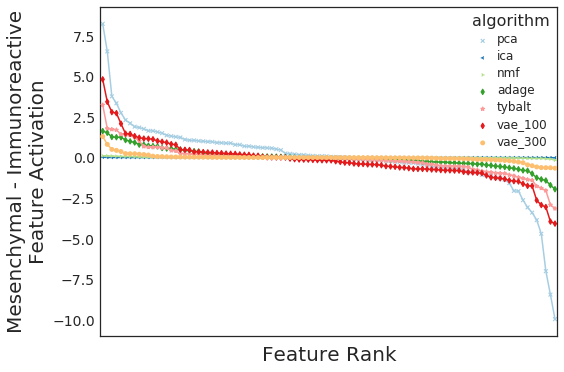

In [16]:
latent_space_figure = os.path.join('figures', 'algorithm_comparison_latent_space.png')
ax = sns.pointplot(x='rank',
                   y='activation',
                   hue='algorithm',
                   data=long_latent_space_df,
                   palette=algorithm_color_dict,
                   markers=['x', '3', '4', 'd', '*', 'd','o'],
                   orient='v',
                   scale=0.6)
ax.set_xlabel('Feature Rank')
ax.set_ylabel('Mesenchymal - Immunoreactive\nFeature Activation')

ax.set(xticklabels=[]);
plt.tight_layout()

plt.setp(ax.get_legend().get_texts(), fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='16')
plt.savefig(latent_space_figure, dpi=600, height=6, width=5)

### Part II. Extract high weight genes from each most explanatory feature

In [17]:
algorithms = ['PCA', 'ICA', 'NMF', 'adage', 'tybalt', 'vae_100', 'vae_300']

In [18]:
def get_high_weight_genes(weight_matrix, node, algorithm, high_std=2.5, direction='positive',
                          output_file=''):
    """
    Determine high weight genes given a gene weight matrix and feature
    
    Arguments:
    weight_matrix - pandas DataFrame storing gene weights for each feature
    node - An integer representing the index of the feature of interest
    algorithm - A string that will be included as a column in the output DataFrame
    high_std - The cutoff to determine a high weight gene
    direction - A string deciding which tail to consider high weight genes from
    output_file - A string representing a file path to save output. Will not save if empty
    
    Output:
    A tuple consisting of two DataFrames: (high weight genes, all node genes)
    """
    genes = weight_matrix.loc[int(node), :].sort_values(ascending=False)
    if direction == 'positive':
        hw_pos_cutoff = genes.mean() + (genes.std() * high_std)
        node_df = (genes[genes > hw_pos_cutoff])
    elif direction == 'negative':
        hw_neg_cutoff = genes.mean() - (genes.std() * high_std)
        node_df = (genes[genes < hw_neg_cutoff])

    node_df = pd.DataFrame(node_df).reset_index()
    node_df.columns = ['genes', 'weight']
    
    if output_file:
        node_df.to_csv(output_file, index=False, sep='\t')
    
    # Process return data
    genes_df = pd.DataFrame(genes).reset_index()
    genes_df.columns = ['gene', 'activation']
    genes_df = genes_df.assign(algorithm=algorithm)
    
    return (node_df, genes_df)

In [19]:
# Load feature matrices
feature_matrix = dict()
pca_feature_file = '../pancan_viz/data/pca_feature_rnaseq.tsv.gz'
ica_feature_file = '../pancan_viz/data/ica_feature_rnaseq.tsv.gz'
nmf_feature_file = '../pancan_viz/data/nmf_feature_rnaseq.tsv.gz'
adage_feature_file = 'https://github.com/greenelab/tybalt/raw/4bb7c5c5eb6b9dfe843269f8c3059e1168542b55/results/adage_gene_weights.tsv'
tybalt_feature_file = 'https://github.com/greenelab/tybalt/raw/928804ffd3bb3f9d5559796b2221500c303ed92c/results/tybalt_gene_weights.tsv'
vae_feature_twolayer_file = 'https://github.com/greenelab/tybalt/raw/7d2854172b57efc4b92ca80d3ec86dfbbc3e4325/data/tybalt_gene_weights_twohidden100.tsv'
vae_feature_twolayer300_file = 'https://github.com/greenelab/tybalt/raw/7d2854172b57efc4b92ca80d3ec86dfbbc3e4325/data/tybalt_gene_weights_twohidden300.tsv'

feature_matrix['PCA'] = pd.read_table(pca_feature_file, index_col=0)
feature_matrix['ICA'] = pd.read_table(ica_feature_file, index_col=0)
feature_matrix['NMF'] = pd.read_table(nmf_feature_file, index_col=0)
feature_matrix['adage'] = pd.read_table(adage_feature_file, index_col=0)
feature_matrix['tybalt'] = pd.read_table(tybalt_feature_file, index_col=0)
feature_matrix['vae_100'] = pd.read_table(vae_feature_twolayer_file, index_col=0)
feature_matrix['vae_300'] = pd.read_table(vae_feature_twolayer300_file, index_col=0)

In [20]:
# This is the largest difference in the Mesenchymal subtype across various algorithms
latent_space_df.head(1)

,pca_features,pca,ica_features,ica,nmf_features,nmf,adage_features,adage,tybalt_features,tybalt,vae_100_features,vae_100,vae_300_features,vae_300
0,1,8.245418,32,0.021696,75,0.111632,32,1.63094,87,3.247565,62,4.821263,87,1.30118


In [21]:
base_dir = os.path.join('results', 'feature_comparison')
algorithm_genes = dict()
node_genes = dict()
for alg in algorithms:
    # Generate output file
    alg_lower = alg.lower()
    out_gene_file = '{}_mesenchymal_genes.tsv'.format(alg_lower)
    out_gene_file = os.path.join(base_dir, out_gene_file)

    # Subset specific node
    node_label = '{}_features'.format(alg_lower)
    node = latent_space_df.loc[0, node_label]
    
    # Subset feature matrix
    weight_df = feature_matrix[alg]

    # Relax threshold for PCA since no genes are beyond
    if alg == "PCA":
        thresh = 1.5
    else:
        thresh = 2.5

    # Identify algorithm genes
    node_genes[alg], algorithm_genes[alg] = (
        get_high_weight_genes(weight_matrix=weight_df,
                              node=node,
                              algorithm=alg,
                              high_std=thresh,
                              direction='positive',
                              output_file=out_gene_file)
    )

In [22]:
feature_activation_df = pd.concat([algorithm_genes['PCA'],
                                   algorithm_genes['ICA'],
                                   algorithm_genes['NMF'],
                                   algorithm_genes['adage'],
                                   algorithm_genes['tybalt']], axis=0)
print(feature_activation_df.shape)
feature_activation_df.head(5)

(25000, 3)


,gene,activation,algorithm
0,ATP6V1G2,0.032836,PCA
1,ATP1B2,0.032606,PCA
2,DCLK2,0.032291,PCA
3,CYP46A1,0.030947,PCA
4,ELAVL3,0.030932,PCA


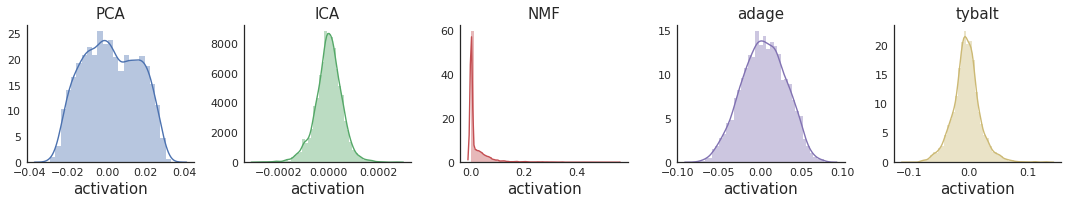

In [23]:
# Visualize distribution of features to assess normality
sns.set_context('paper', rc={'font.size': 12,
                             'axes.titlesize': 20,
                             'axes.labelsize': 15,
                             'xtick.labelsize': 11,
                             'ytick.labelsize': 11})

g = sns.FacetGrid(feature_activation_df,
                  col='algorithm',
                  sharex=False,
                  sharey=False,
                  hue='algorithm')

g.map(sns.distplot, 'activation');
g.set_titles(col_template = '{col_name}')

file = os.path.join('figures', 'example_distributions.png')
plt.savefig(file,
            dpi=600,
            height=3,
            width=5)